## pix2pix pytorch lightning

### Data loader

In [1]:
%matplotlib inline
import os
import sys
from PIL import Image
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os
import torchvision
from argparse import ArgumentParser, Namespace
from collections import OrderedDict


In [3]:
from models.pix2pix.datasets import ImageDataset

import albumentations as A

In [4]:
dataset_name = "mini_pix2pix"
img_height = 256
img_width = 256

In [5]:
transforms_ = [
            A.RandomResizedCrop(
                img_height,
                img_width,
            ),
            A.Rotate(13),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(),
            A.HueSaturationValue(),
            A.RGBShift(),
            A.RandomGamma(),
            # A.CLAHE(),
#             MyCoarseDropout(
#                 min_holes=1,
#                 max_holes=8,
#                 max_height=32,
#                 max_width=32,
#             ),
            # A.Resize(img_size, img_size, interpolation=cv2.INTER_CUBIC),
#             A.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225],
#             ),
            # ToTensorV2(),
        ]

dataset = ImageDataset("./datasets/%s" % dataset_name, transforms_=transforms_)

In [6]:
len(dataset)

20

In [7]:
def draw(A, B):    
    fig = plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(A)
    plt.title('original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(B)
    plt.title('mask')
    plt.axis('off')
    plt.show()

In [8]:
item = dataset[10]

In [11]:
item['A'].shape

(256, 256, 3)

In [9]:
item_a = (item['A']*255).transpose((1, 2, 0)).astype(np.uint8)

In [10]:
item_a.shape

(256, 3, 256)

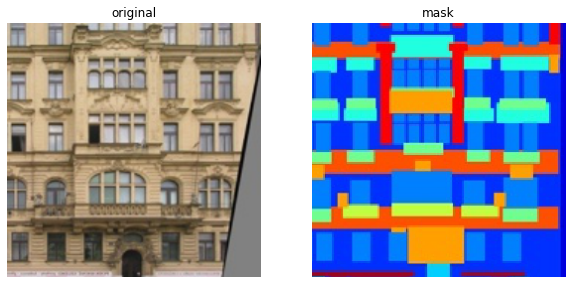

In [12]:
draw(item['A'], item['B'])

In [13]:
item['A'].shape

(256, 256, 3)

### Train

In [14]:
from pytorch_lightning.trainer import Trainer
from models.pix2pix_model import Pix2PixModel

In [15]:
model = Pix2PixModel()

In [16]:
train_loader = model.train_dataloader()

In [17]:
for batch in train_loader:
    print(batch['A'].shape)
    break

torch.Size([1, 256, 256, 3])


In [18]:
trainer = Trainer(gpus=[0], max_epochs=100)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type          | Params
------------------------------------------------------
0 | generator           | GeneratorUNet | 54 M  
1 | discriminator       | Discriminator | 2 M   
2 | criterion_GAN       | MSELoss       | 0     
3 | criterion_pixelwise | L1Loss        | 0     
/home/nghia/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/nghia/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in t

RuntimeError: Given groups=1, weight of size [64, 3, 4, 4], expected input[1, 256, 256, 3] to have 3 channels, but got 256 channels instead